# Dependencies 

## Imports 

In [1]:
# imports 
# base python
import os
import copy
import re
from sys import getsizeof
import random

# scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, mpld3
%matplotlib inline
import seaborn as sns
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d, interp2d
from sklearn.metrics.pairwise import rbf_kernel
from sklearn import preprocessing
import matplotlib.tri as tri
from sklearn.manifold import MDS
from sklearn.manifold import TSNE

plt.rcParams["figure.figsize"] = (20,7)

#ase
from ase.io import gen, vasp, xyz, extxyz, dftb
from ase.io.dftb import read_dftb_velocities, write_dftb_velocities
from ase.calculators.dftb import Dftb
from ase import Atoms, Atom
from ase.constraints import FixAtoms
from ase.visualize import view
from ase.build import make_supercell
from ase.visualize.plot import plot_atoms
from ase.build import add_adsorbate
import nglview
from ase.geometry.analysis import Analysis

#dscribe
from dscribe.descriptors import SOAP
from dscribe.descriptors import MBTR
from dscribe.kernels import REMatchKernel
from dscribe.kernels import AverageKernel

from sklearn import preprocessing


#quippy 
from ase.build import bulk
from ase.optimize import LBFGS
from ase.visualize import view
from quippy.potential import Potential


#misc
import similaritymeasures


_ColormakerRegistry()

## Functions

In [121]:
def show_atoms_grid(data, rotation = '-0x,0y,0z', save= False, filename = 'grid_configs'):
    '''
    Where data is list of Atoms objects
    '''
    dim = int(np.ceil(np.sqrt(len(data))))
    fig, axarr = plt.subplots(dim, dim, figsize=(25, 25))
    for i, config in enumerate(data):
        plot_atoms(config, axarr[i%dim,i//dim], rotation = rotation)
    if save:
        fig.savefig(filename + ".png")
        
def normalize(y,x):
    """
    Takes y, x of data and returns normalized y
    """
    return y/np.trapz(y,x)

def KE(v_tot):
    "Returns KE of Ar+ in eV given total velocity"
    return 6.24E18 * 0.5 * 1.66E-27*39.95*(v_tot*1E5)**2

def v_from_KE(E):
    "Returns v(z) of Ar+ in eV given KE"
    return np.sqrt(E/(6.24E18 * 0.5 * 1.66E-27*39.95))/1E5

def readStructs(datadir, slabEnergy, adsorbateEnergy):
    """
        Currently designed for output from single layer directory trees 
        Reads in final adsorption geometries and energy data,
            returns dataframe with geometry and energy data
            
        Input:
            datadir: string that points to directory containing the following:
                - convergence: each line i has convergence status of run i
                - energies: each line i has final total energy from run i
                - output{indices}.gen: final geometries for each index
            slabEnergy: energy of slab
            adsorbateEnergy: energy of the adsorbate in the system
        Output:
            output: pd Dataframe with:
                - index: indices for runs that worked
                - geometry: final geometry of run
                - total energy: raw energy from file
                - adsorption energy: energy as adjusted by adsorbate_energy
    """
    geometries = {}
    convergence = pd.read_csv(datadir + "convergence", header = None)
    energies = pd.read_csv(datadir + "energies", header = None)
    output =  pd.concat([energies, convergence], axis = 1)
    output.columns = ["E", "conv"]
    
    for i in os.listdir(datadir):
        key = re.search(r"output(\d+).gen", i)
        if key:
            key = int(key.group(1))
            geometries[key] =  gen.read_gen(datadir + i)
    output['geom'] = pd.Series(geometries)
    
    output = output[output['conv'] == "Geometry converged"]
    output = output.drop("conv", axis = 1)
    
    output['E_ads'] = output["E"] - (adsorbateEnergy + slabEnergy)
    return output


def convertAdsorbateToHe(struct, centerIndex, molIndices, height = None):
    """
    Preprocess final relaxed adsorption structures; replace adsorbate with He 
    Input:
        struct: total structure (Atoms object)
        centerIndex: index of central atom (where He will be) (int)
        molIndices: list of indices to delete from the slab
        height(float) : height of He to be placed
    Output:
        output: Atoms object with He representing the location of the adsorbate
    """
    x, y, z = struct[centerIndex].position
    output = struct.copy()
    del output[[atom.index for atom in output if atom.index in molIndices]]
    if height:
        add_adsorbate(output, "He", height = height, position = (x, y))
    else:
        output.append(Atom("He", position=[x,y,z])) # adds to exact position of centeratom 
    return output


def getSOAPs(geometries, rcut = 5, nmax = 10, lmax = 9, sigma = 0.1, 
             periodic = True, crossover = True, sparse = False):
    """
    Takes a Series of geometries with one He present, 
        returns SOAP representation of the chemical environment of He for each item
    Assumes any given structure in `geometries` has the same collection of elements 
        as all the other structures
    Assumes any given structure in `geometries` has the same number of atoms as all 
        the other structures
    
    Input:
        geometries: Series of Atoms objects; each must contain exactly 1 He atom
        rcut, nmax, lmax, sigma, periodic, crossover, sparse: SOAP parameters
    Output:
        output: Series of SOAP matrices, each corresponding to the appropriate index
    """
    refgeom = geometries.iloc[0] #use the first geometry as a reference geometry
    
    ## set up descriptor
    species = np.unique([i.symbol for i in refgeom])
    desc = SOAP(species=species, rcut = rcut, nmax = nmax, lmax = lmax, 
                sigma = sigma, periodic = periodic, crossover = crossover, sparse = sparse)
    ## apply descriptor
    soaps = {}
    HeLoc = len(refgeom) - 1  # assume He atom is last one in Atoms list
    for i, geom in geometries.iteritems():
        tempSOAP = preprocessing.normalize(
            desc.create(geom, positions = [HeLoc])) # SOAP representation of temp 
        soaps[i] = tempSOAP[0]
    return pd.Series(soaps,name = 'SOAP')

## Structures

In [98]:
mef = vasp.read_vasp("reference_files/CONTCAR_mef")
cf4 = vasp.read_vasp("reference_files/CONTCAR_cf4")
amorphous = vasp.read_vasp("reference_files/CONTCAR_amorphous_cubic")
xtl_n = vasp.read_vasp("reference_files/CONTCAR_nrich")
xtl_si = vasp.read_vasp("reference_files/CONTCAR_sirich")
xtl2x2 = gen.read_gen("reference_files/2x2xtl.gen")
xtl2x2_sifterm = gen.read_gen("reference_files/2x2xtl_sifterm.gen")
heavy_bomb = vasp.read_vasp("reference_files/CONTCAR_heavy_bombard")
bulk222 = vasp.read_vasp("reference_files/CONTCAR_222bulk")
annealed = vasp.read_vasp("reference_files/CONTCAR_annealed_unitcell")

# Preprocess data

Read in geometries

In [186]:
data = readStructs("../adsorb_amorphous/", -196.0817, -16828.7803) #MeF, amorphous slab, DFTB
data['processed'] = [
    convertAdsorbateToHe(i, 370, np.arange(370, 375)) for i in data['geom']
]

data = pd.concat([data, getSOAPs(data['processed'])], axis = 1)

originalColumns = data.columns

data = pd.concat([pd.DataFrame(data['SOAP'].to_list(), index = data.index), data], axis = 1)

# Visualize data

Check for positive adsorption energies:

In [187]:
data[data["E_ads"] > 0][originalColumns]

,E,geom,E_ads,processed,SOAP
7,-17024.5855,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...",0.2765,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.8773076e-10, -2.8960547e-09, 1.07410685e-08..."
42,-17023.3445,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...",1.5175,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[1.2610807e-11, -1.0335893e-09, 7.199541e-09, ..."
44,-17023.3552,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...",1.5068,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.980705e-10, -6.139825e-09, 4.5810843e-08, -..."
45,-17023.4530,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...",1.4090,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[4.3263764e-11, -4.030708e-10, 2.0436997e-09, ..."
46,-17023.3341,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...",1.5279,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[9.240166e-11, -5.0285864e-09, 4.0425714e-08, ..."
47,-17023.2953,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...",1.5667,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[7.5724965e-10, -1.546233e-08, 1.0510201e-07, ..."
48,-17023.2569,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...",1.6051,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[4.500972e-09, -3.016053e-08, 9.173593e-08, 8...."
49,-17023.3570,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...",1.5050,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[1.2691453e-11, 5.200569e-11, -8.765282e-10, 2..."
50,-17023.3615,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...",1.5005,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[4.8403788e-09, -3.044454e-08, 7.810141e-08, 1..."
51,-17023.2962,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...",1.5658,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[6.5946354e-10, -1.41879255e-08, 9.766472e-08,..."


Summarize data:

In [180]:
data["E_ads"].describe()

count    93.000000
mean      0.409439
std       0.814419
min      -0.458600
25%      -0.180300
50%      -0.122800
75%       1.495000
max       1.621400
Name: E_ads, dtype: float64

# Adaptive sampling?

# Train

For now, just remove points that have positive adsorption energy 

In [252]:
from sklearn.model_selection import train_test_split
validData = data['E_ads'] < 0
X_train, X_test, y_train, y_test = train_test_split(
    data.loc[validData, ~np.in1d(data.columns, originalColumns)], 
    data.loc[validData, 'E_ads'], random_state = 429)
print("# points total: %d; #train points: %d; #test points: %d" % 
      (sum(validData), len(X_train), len(X_test)))

# points total: 60; #train points: 45; #test points: 15


Run KRR with grid CV search

In [274]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
alphas = np.logspace(-10, -2, 50)
krr = KernelRidge()  # gamma automatically set by sklearn.metrics.pairwise.rbf_kernel
model = GridSearchCV(krr, [{"alpha":alphas}], cv = 5)
model.fit(np.array(X_train), np.array(y_train))

GridSearchCV(cv=5, error_score=nan,
             estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                   kernel='linear', kernel_params=None),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e-10, 1.45634848e-10, 2.12095089e-10, 3.08884360e-10,
       4.49843267e-10, 6.55128557e-10, 9.54095476e-10, 1.38949549e-09,
       2.02358965e-09, 2.94705170e-09, 4.29193426e-09,...
       1.67683294e-05, 2.44205309e-05, 3.55648031e-05, 5.17947468e-05,
       7.54312006e-05, 1.09854114e-04, 1.59985872e-04, 2.32995181e-04,
       3.39322177e-04, 4.94171336e-04, 7.19685673e-04, 1.04811313e-03,
       1.52641797e-03, 2.22299648e-03, 3.23745754e-03, 4.71486636e-03,
       6.86648845e-03, 1.00000000e-02])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Optimal model result:

In [276]:
model.best_params_

{'alpha': 5.428675439323859e-06}

# Assess

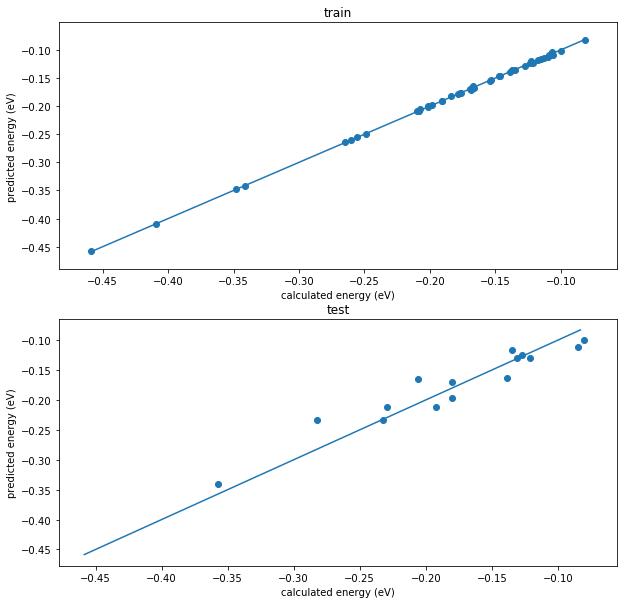

In [277]:
plt.subplots(2, 1, figsize = (10, 10))

plt.subplot(211)
plt.title('train')
plt.ylabel("predicted energy (eV)")
plt.xlabel("calculated energy (eV)")
train_predict = model.predict(X_train)
plt.scatter(y_train, train_predict)
lineparams = [min(y_train), max(train_predict)]
plt.plot(lineparams, lineparams)
plt.subplot(212)
plt.title("test")
plt.ylabel("predicted energy (eV)")
plt.xlabel("calculated energy (eV)")
plt.scatter(y_test, model.predict(X_test))
plt.plot(lineparams, lineparams);

## Plot residuals

Considering the true model should simply be y = x, we can plot residuals and assess MAE easily:

In [281]:
train_errs = y_train - model.predict(X_train)

In [282]:
test_errs = y_test - model.predict(X_test)

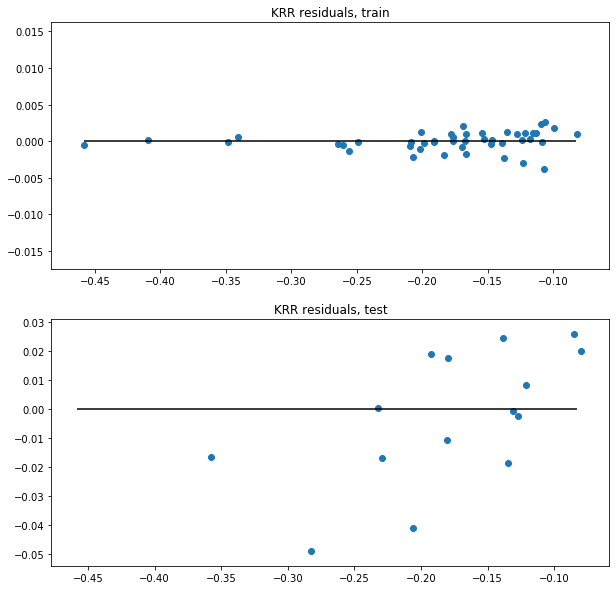

In [283]:
plt.subplots(2, 1, figsize = (10, 10))
plt.subplot(211)
plt.title("KRR residuals, train")
plt.scatter(y_train, train_errs);
plt.hlines(0, *lineparams)
plt.subplot(212)
plt.title("KRR residuals, test")
plt.hlines(0, *lineparams)
plt.scatter(y_test, test_errs);

In [285]:
print("MAE train (eV): %f \n\
MAE test (eV): %f" % 
      (np.mean(np.abs(train_errs)),
       np.mean(np.abs(test_errs))
      ))

MAE train (eV): 0.000977 
MAE test (eV): 0.018077


In [289]:
print("Relative absolute error train (eV): %f \n\
Relative absolute error test (eV): %f" % 
      (np.mean(np.abs(train_errs))/np.abs(np.mean(y_train)),
       np.mean(np.abs(test_errs)/np.abs(np.mean(y_test)))
      ))

Relative absolute error train (eV): 0.005350 
Relative absolute error test (eV): 0.101325
